# Example Using  `dask.delayed`  with PyRosetta

*Note:* This Jupyter notebook uses parallelization and is **not** meant to be executed within a Google Colab environment.

In [3]:
import dask
import graphviz
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
import os
import pyrosetta
import pyrosetta.distributed
import pyrosetta.distributed.dask
import random
import sys

from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

if 'google.colab' in sys.modules:
    print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
    sys.exit(0)

Initialize this Jupyter Notebook with custom command line PyRosetta flags:

In [2]:
flags = """-out:level 100
-ignore_unrecognized_res   1
     -ignore_waters 0 
  -detect_disulf  0 # Do not automatically detect disulfides
""" # These can be unformatted for user convenience, but no spaces in file paths!
pyrosetta.distributed.init(flags)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:level 100 -ignore_unrecognized_res 1 -ignore_waters 0 -detect_disulf 0', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


Now we will use the `SLURMCluster` function in the `dask_jobqueue` module, specifying to preload workers with the same custom command line PyRosetta flags using the `extra=pyrosetta.distributed.dask.worker_extra(init_flags=flags)` option.

In [4]:
if not os.getenv("DEBUG"):
    scratch_dir = os.path.join("/net/scratch", os.environ["USER"])
    cluster = SLURMCluster(cores=1,
                           processes=1,
                           job_cpu=1,
                           memory="4GB",
                           queue="interactive",
                           walltime="12:00:00",
                           local_directory=scratch_dir,
                           job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))],
                           extra=pyrosetta.distributed.dask.worker_extra(init_flags=flags))
    cluster.scale(4)
    client = Client(cluster)

/home/klimaj/anaconda3/envs/pyrosetta-bootcamp/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [5]:
if not os.getenv("DEBUG"):
    client

Client Scheduler: tcp://172.16.131.35:25583 Dashboard: http://172.16.131.35:20293/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Let's look at a simple example of sending PyRosetta jobs to the `dask-worker`, and the `dask-worker` sending the results back to this Jupyter Notebook.

We will use the crystal structure of the *de novo* mini protein gEHEE_06 from PDB ID 5JG9

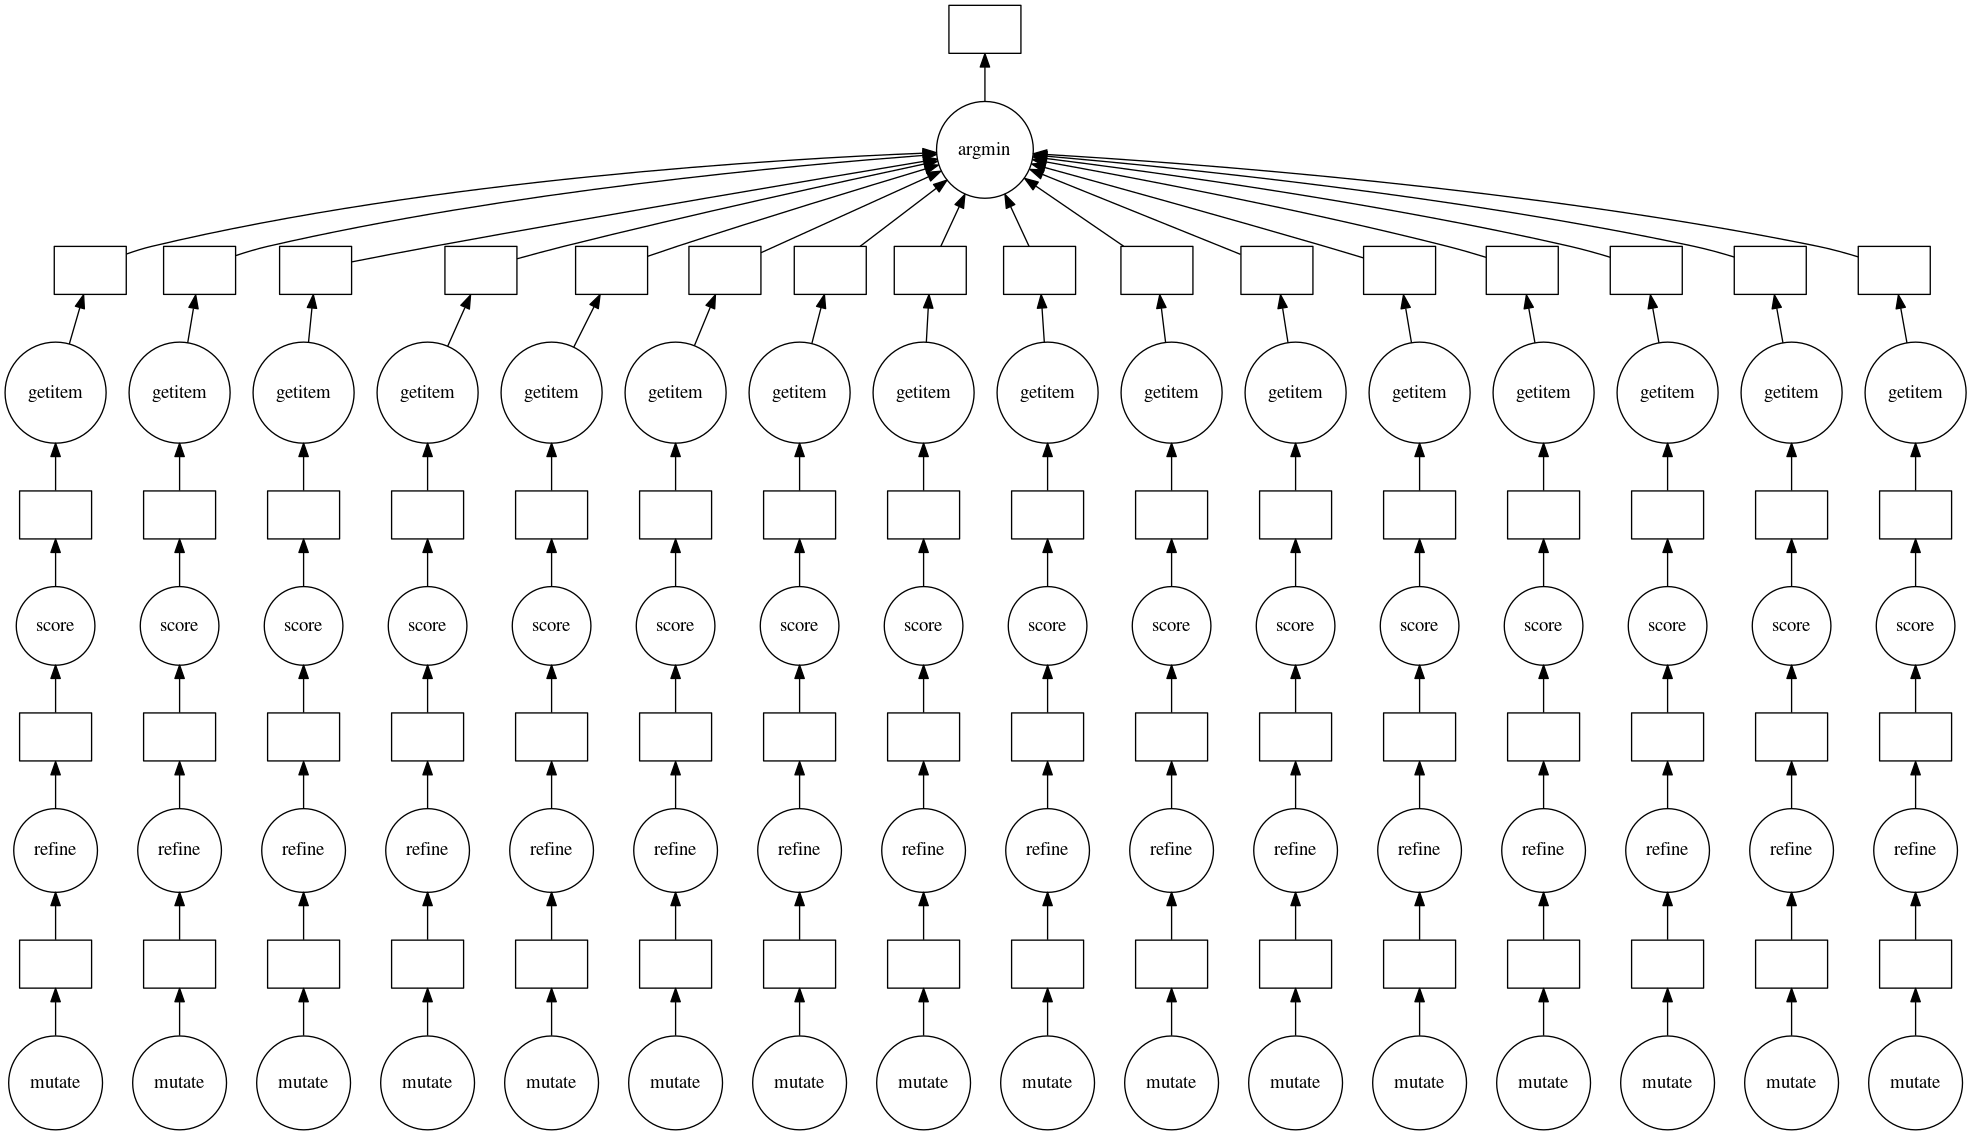

In [6]:
@dask.delayed
def mutate(pose, target, new_res):
    mutate = pyrosetta.rosetta.protocols.simple_moves.MutateResidue(target=target, new_res=new_res)
    mutate.apply(pose)
    return pose


@dask.delayed
def refine(pose):
    scorefxn = pyrosetta.create_score_function("ref2015_cart")
    mm = pyrosetta.rosetta.core.kinematics.MoveMap()
    mm.set_bb(True)
    mm.set_chi(True)
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.set_movemap(mm)
    min_mover.score_function(scorefxn)
    min_mover.min_type("lbfgs_armijo_nonmonotone")
    min_mover.cartesian(True)
    min_mover.tolerance(0.01)
    min_mover.max_iter(200)
    min_mover.apply(pose)
    return pose


@dask.delayed
def score(pose):
    scorefxn = pyrosetta.create_score_function("ref2015")
    total_score = scorefxn(pose)
    return pose, total_score


pose = pyrosetta.io.pose_from_file("inputs/5JG9.clean.pdb")
keep_chA = pyrosetta.rosetta.protocols.grafting.simple_movers.KeepRegionMover(
    res_start=str(pose.chain_begin(1)), res_end=str(pose.chain_end(1))
)
keep_chA.apply(pose)

output = []
for target in random.sample(range(1, pose.size() + 1), 10):
    if pose.sequence()[target - 1] != "C":
        for new_res in ["ALA", "TRP"]:
            a = mutate(pose, target, new_res)
            b = refine(a)
            c = score(b)
            output.append((target, new_res, c[0], c[1]))

delayed = dask.delayed(np.argmin)([x[-1] for x in output])
delayed.visualize()

In [7]:
print(output)

[(15, 'ALA', Delayed('getitem-3b86bd5e8d89abcd8c40ca101baffabc'), Delayed('getitem-549c3a58daa56f97484ec40ec856a99d')), (15, 'TRP', Delayed('getitem-6034e9554f297900f4a8fb596401c6ea'), Delayed('getitem-1460b0a62d786c7ae1c9317495577370')), (35, 'ALA', Delayed('getitem-606b498aca32b3d28c6dc25999f7a8ea'), Delayed('getitem-787fc4fbefa4ef8bbf36814d0ef1cd2a')), (35, 'TRP', Delayed('getitem-001127da7dc5fbc4e677dde174d7bf62'), Delayed('getitem-833aab85f462f5d89eb5c327260fe48c')), (3, 'ALA', Delayed('getitem-e65189f3fc8aa2c4803011fbbda1362f'), Delayed('getitem-5e391f7c94c1455e6282021168a75d3c')), (3, 'TRP', Delayed('getitem-c5b30b3192ba863c9581f5d238c5533f'), Delayed('getitem-9404a8a66c4c65f06f723fdd7cf1e30b')), (6, 'ALA', Delayed('getitem-a0974b65a210ea7b4dc143aaf18ff59a'), Delayed('getitem-598dfb0b72bfc7fe5948128092a00ad5')), (6, 'TRP', Delayed('getitem-c67156e8c96c9c8e6881acaf79145d49'), Delayed('getitem-f6fc3e84d862cce150b7747a92e3c2d0')), (27, 'ALA', Delayed('getitem-92aee76620d6a5192d9ac2

In [8]:
if not os.getenv("DEBUG"):
    delayed_result = delayed.persist()
    progress(delayed_result)

VBox()

In [9]:
if not os.getenv("DEBUG"):
    result = delayed_result.compute()
    print("The mutation with the lowest energy is residue {0} at position {1}".format(output[result][1], output[result][0]))

The mutation with the lowest energy is residue ALA at position 3


*Note*: For best practices while using `dask.delayed`, see: http://docs.dask.org/en/latest/delayed-best-practices.html